In [0]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (TensorDataset, DataLoader)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
from torchvision import transforms
from torchvision.datasets import EMNIST
from torch.utils.data.dataset import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

In [2]:
dataset = EMNIST(root = '/', train = True, split = 'letters', transform = transforms.ToTensor(), download = True)

Extracting /EMNIST/raw/emnist.zip to /EMNIST/raw
Processing byclass


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


In [0]:
test_dataset = EMNIST(root = '/', train = False, split = 'letters', transform = transforms.ToTensor(), download = True)

In [4]:
input_size = 28*28
output_size = len(dataset.classes)
input_size, output_size

(784, 26)

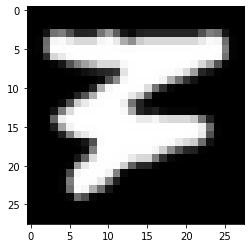

In [5]:
image, label = dataset[0]
plt.imshow(image[0, :, :], cmap = 'gray')

In [6]:
val_size = int(0.2*len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(99840, 24960)

In [0]:
batch_size = 256

In [0]:
train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = batch_size, shuffle = True, num_workers = 4, pin_memory = True)

In [0]:
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 4, pin_memory = True)

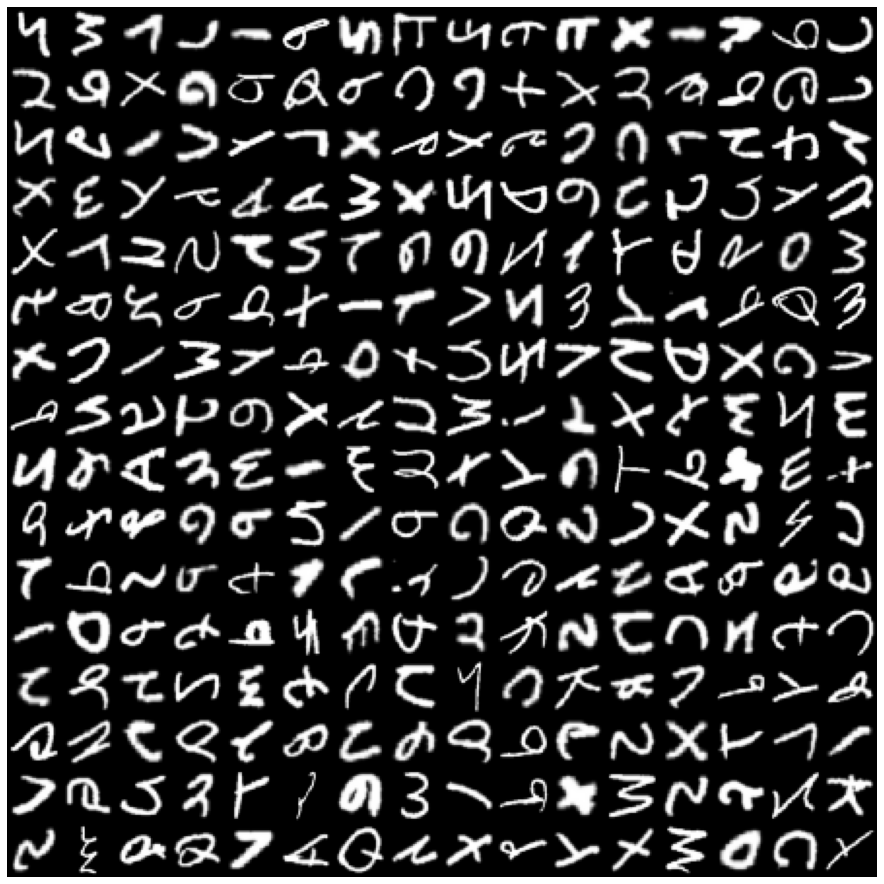

In [10]:
for images, _ in train_loader:
  plt.figure(figsize = (16, 16))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow = 16, padding = 0).permute(1, 2, 0))
  break

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [0]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

In [0]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for batch in self.dl:
      yield to_device(batch, self.device)

In [0]:
train_ddl = DeviceDataLoader(train_loader, device)
val_ddl = DeviceDataLoader(val_loader, device)

In [15]:
class EMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, output_size)
  def forward(self, images):
    return self.linear(images.reshape(-1, 28*28))

model = EMNIST()
to_device(model, device)

EMNIST(
  (linear): Linear(in_features=784, out_features=26, bias=True)
)

In [0]:
loss_function = F.cross_entropy

In [17]:
# loss for current batch
for images, labels in train_ddl:
  outputs = model(images)
  break
loss = loss_function(outputs, labels).item()
loss

3.2661068439483643

In [0]:
def find_accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim =1)
  return ((preds == labels).sum()).item() / len(preds)

In [19]:
find_accuracy(outputs, labels)

0.046875

In [30]:
class EMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, output_size)

  def forward(self, images):
    return self.linear(images.reshape(-1, 28*28))

  def training_batch(self, batch):
    images, labels = batch
    outputs = self.forward(images)
    loss = F.cross_entropy(outputs, labels)
    return loss

  def validation_batch(self, batch):
    images, labels = batch
    outputs = self.forward(images)
    loss = F.cross_entropy(outputs, labels).item()
    accuracy = find_accuracy(outputs, labels)
    return {'val_loss' : loss, 'val_accuracy' : accuracy}

  def validation_end_epoch(self, outputs):
    epoch_loss = sum([x['val_loss'] for x in outputs]) / len(outputs)
    epoch_accuracy = sum([x['val_accuracy'] for x in outputs]) / len(outputs)
    return {'epoch_loss' : epoch_loss, 'epoch_accuracy' : epoch_accuracy}

model = EMNIST()
to_device(model, device)

EMNIST(
  (linear): Linear(in_features=784, out_features=26, bias=True)
)

In [0]:
def validate(model, val_ddl):
  outputs = [model.validation_batch(batch) for batch in val_ddl]
  return model.validation_end_epoch(outputs)

def fit(model, epochs, learning_rate, train_ddl, val_ddl, optimization_func = torch.optim.SGD):
  history = []
  optimizer = optimization_func(model.parameters(), learning_rate)
  for epoch in range(epochs):
    for batch in train_ddl:
      loss = model.training_batch(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result = validate(model, val_ddl)
    history.append(result)
    print('Epoch: {}, Validation loss: {}, Validation accuracy: {}'.format(epoch, result['epoch_loss'], result['epoch_accuracy']))

In [31]:
validate(model, val_ddl)

{'epoch_accuracy': 0.04440369897959184, 'epoch_loss': 3.245704611953424}

In [38]:
fit(model, 5, 0.01, train_ddl, val_ddl)

Epoch: 0, Validation loss: 1.7148235878165887, Validation accuracy: 0.5615035076530612
Epoch: 1, Validation loss: 1.6183632831184231, Validation accuracy: 0.5744977678571429
Epoch: 2, Validation loss: 1.5552939042753102, Validation accuracy: 0.5847417091836735
Epoch: 3, Validation loss: 1.5124402812549047, Validation accuracy: 0.5928730867346939
Epoch: 4, Validation loss: 1.4755299906341397, Validation accuracy: 0.599250637755102


In [40]:
fit(model, 5, 0.1, train_ddl, val_ddl)

Epoch: 0, Validation loss: 1.2917581942616676, Validation accuracy: 0.6460459183673469
Epoch: 1, Validation loss: 1.2550683714905564, Validation accuracy: 0.6560108418367347
Epoch: 2, Validation loss: 1.2393143724422067, Validation accuracy: 0.6590401785714286
Epoch: 3, Validation loss: 1.2249356252806527, Validation accuracy: 0.6657764668367347
Epoch: 4, Validation loss: 1.2173986447100738, Validation accuracy: 0.6691246811224489


In [41]:
fit(model, 10, 0.3, train_ddl, val_ddl)

Epoch: 0, Validation loss: 1.2012504655487684, Validation accuracy: 0.6713169642857143
Epoch: 1, Validation loss: 1.191073207830896, Validation accuracy: 0.6756616709183674
Epoch: 2, Validation loss: 1.1775376912282438, Validation accuracy: 0.6788903061224489
Epoch: 3, Validation loss: 1.178369618192011, Validation accuracy: 0.6790896045918368
Epoch: 4, Validation loss: 1.1780699673964052, Validation accuracy: 0.6790098852040817
Epoch: 5, Validation loss: 1.1703006460958598, Validation accuracy: 0.6812021683673469
Epoch: 6, Validation loss: 1.1645836611183322, Validation accuracy: 0.681999362244898
Epoch: 7, Validation loss: 1.1668095990103118, Validation accuracy: 0.6842315051020408
Epoch: 8, Validation loss: 1.1658243494374412, Validation accuracy: 0.6834343112244898
Epoch: 9, Validation loss: 1.1691432102602355, Validation accuracy: 0.6822385204081632
